<a href="https://colab.research.google.com/github/ALXAVIER-DEV/Spark/blob/master/Aula_7_Distributed_Shared_Variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 3.0.1 with hadoop 2.7 and Java 8. The tools installation can be carried out inside the Jupyter Notebook of the Colab. One important note is that if you are new in Spark, it is better to avoid Spark 2.4.0 version since some people have already complained about its compatibility issue with python. 
Follow the steps to install the dependencies:

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark

Now that you installed Spark and Java in Colab, it is time to set the environment path which enables you to run Pyspark in your Colab environment. Set the location of Java and Spark by running the following code:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Run a local spark session to test your installation:

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
spark

# Reading a CSV from google drive

Utilizando o Google Colab, é possível importar os datasets diretamente do Google Drive, sem ter que realizar o upload manual dos mesmos para a instância colab manualmente

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
spark.read\
  .option("inferSchema", "true") \
  .option("header", "true") \
  .option("delimiter", ",") \
  .csv("drive/My\ Drive/My\ Professional\ Carrer/Spark\ course/virtual_classroom/colab_test/test.csv") \
  .show()

# Distributed Shared Variables
Além dos RDDs, as APIs low-level do Spark fornecem operações para trabalhar com variáveis distribuídas e compartilhadas ao longo do cluster. São elas
1. Broadcast variables
2. Accumulators

### Broadcast variables
As Broadcast variables podem ser entendidas da seguinte forma:

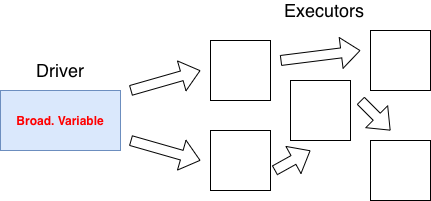

Basicamente, uma varíavel de broadcast é criada no Driver da aplicação e depois armazenada em cada executor. Esse recurso é útil quando se tem a necessidade de passar um parâmetro grande (um grande dicionário em Python ou um modelo de Machine Learning) dentro de funções utilizadas em `UDFs` ou operações do tipo `map`. A principal vantagem é:

- Utilizando as Broadcast variables, não é necessário reenviar a mesma estrutura de dados a cada job para os executores porque isso implica em **serializar/deserializar** aquela estrutura repetidamente

Obs.: As Broadcast Variables só são de fato distribuídas ao longo dos executores quando ocorre uma ação devido ao conceito de *Lazy Evaluation*

##### Criando um RDD simples

In [ ]:
sc = spark.sparkContext

In [ ]:
my_collection = "Spark The Definitive Guide : Big Data Processing Made Simple".split(" ")
words = spark.sparkContext.parallelize(my_collection, 2)

In [ ]:
words.take(10)

##### Definindo a estrutura a ser mantida como Broadcast Variable

In [ ]:
supplemental_data = {"Spark":1000, "Definitive":200, "Big":-300, "Simple":100}

In [ ]:
supplemental_data.get("Igor", 0)

##### Criando a Broadcast Variable

In [ ]:
supp_broadcast = sc.broadcast(supplemental_data)

In [ ]:
supp_broadcast.value["Guide"] = 50

In [ ]:
supp_broadcast.value

{'Big': -300,
 'Definitive': 200,
 'Guide': 50,
 'Igor': 10,
 'Simple': 100,
 'Spark': 1000}

##### Usando a Broadcast Variable

In [ ]:
words \
    .map(lambda word: (word, supp_broadcast.value.get(word, 0)))\
    .sortBy(lambda wordPair: wordPair[1])\
    .collect()

[('Big', -300),
 ('The', 0),
 ('Guide', 0),
 (':', 0),
 ('Data', 0),
 ('Processing', 0),
 ('Made', 0),
 ('Simple', 100),
 ('Definitive', 200),
 ('Spark', 1000)]

### Accumulators
Os Accumlators podem ser entendidos da seguinte forma:

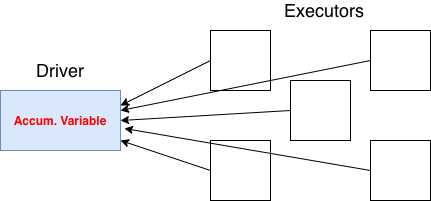

Os Accumulators são uma forma segura e eficiente de atualizar uma um valor ao longo de transformações e propagar esse valor para o Driver da aplicação. O Spark suporta nativamente acumuladores numéricos em que é possível contar ou somar valores

Obs.: Os Accumulators só são de fato executados quando ocorre uma ação devido ao conceito de *Lazy Evaluation*.

##### Criando o Accumulator
O acumulador irá contar a quantidade de linhas que contém a Platform "Wii" 

In [ ]:
acc_wii = sc.accumulator(0)
acc_wii

Accumulator<id=5, value=0>

##### Carregando o dataset em um Dataframe

In [ ]:
data_dir = "vgsales.csv"

df = spark.read.load(data_dir, format="csv", inferSchema="true", header="true")

In [ ]:
df.show()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

##### Definindo a função para incrementar o acumulador

In [ ]:
def acc_wii_platform(row):
  platform = row["Platform"]
  if platform == "Wii":
    acc_wii.add(1)

##### Usando o acumulador

In [ ]:
rdd2 = df.rdd.map(lambda row: acc_wii_platform(row))
a = rdd2.collect()

[None, None, None, None, None, None, None, None, None, None]

In [ ]:
df.foreach(lambda row: acc_wii_platform(row))

In [ ]:
acc_wii.value

1330

'http://3dce5fcc641e:4040'

# Exercícios 

Utilize o RDD abaixo para realizar as questões

1) Realize o output do RDD em uma partição no formato de texto.

In [ ]:
text = "At a high level, every Spark application consists of a driver program that runs the user’s main function and executes various parallel operations on a cluster. The main abstraction Spark provides is a resilient distributed dataset (RDD), which is a collection of elements partitioned across the nodes of the cluster that can be operated on in parallel. RDDs are created by starting with a file in the Hadoop file system (or any other Hadoop-supported file system), or an existing Scala collection in the driver program, and transforming it. Users may also ask Spark to persist an RDD in memory, allowing it to be reused efficiently across parallel operations. Finally, RDDs automatically recover from node failures. A second abstraction in Spark is shared variables that can be used in parallel operations. By default, when Spark runs a function in parallel as a set of tasks on different nodes, it ships a copy of each variable used in the function to each task. Sometimes, a variable needs to be shared across tasks, or between tasks and the driver program. Spark supports two types of shared variables: broadcast variables, which can be used to cache a value in memory on all nodes, and accumulators, which are variables that are only added to, such as counters and sums"
words = text.split(" ")

In [ ]:
rdd = sc.parallelize(words)

rdd.coalesce(1) \
    .saveAsTextFile("./output/words")

2) Utilizando o dicionário de pesos abaixo:

In [ ]:
weights_words = {
    "spark": 1000,
    "parallel": 500,
    "function": 300,
    "driver": 400
}

Escreva um RDD que mostre a palavra, a quantidade de vezes que aquela palavra se repete e o peso dela, dado o RDD de pesos acima (utilizando o conceito de broadcast variable). O que não der match com as chaves disponíveis, atribua o valor -1:

In [ ]:
weights_words = {
    "spark": 1000,
    "parallel": 500,
    "function": 300,
    "driver": 400
}

rdd = sc.parallelize(words)

# definindo a variável de broadcast
weights_broadcast = sc.broadcast(weights_words)

def generate_rdd2(value):
  return 

word_count = rdd \
  .map(lambda line: (line.lower(), 1)) \
  .reduceByKey(lambda left_value, right_value: left_value + right_value) \
  .sortBy(lambda line: line[1] * -1)

word_count.take(10)

[('a', 12),
 ('in', 9),
 ('the', 8),
 ('of', 6),
 ('spark', 6),
 ('and', 5),
 ('be', 5),
 ('to', 5),
 ('parallel', 4),
 ('that', 4)]

3) Escreva um código que conte a quantidade de linhas totais no RDD utilizando os accumulators

In [ ]:
# rdd